<center>
    
    Compression of permutation-invariant images
    
    Author: Daniel Coble
    
    Status: Finished
</center>

This problem is coming up in my work with the Rubik's cube solver. I wanted a way to compress a look-up table, which is a multidimensional array. Fourier-style compression would be difficult since each element has very little to do with its neighbors. However, one trick is that the array is permutation-invariant, i.e. the ordering along each axis does not matter. With that information, the dimensions can be re-ordered to produce large-scale patterns across the array, which can then be compressed. Here, I test the idea with two-dimensional 100x100 arrays filled with random elements between 0 and 1.

To do this, we establish a vector norm of the general form $x^TSx$, where $S$ is the projection matrix for the first $n$ waveforms of the Fourier matrix $F$ (below I choose $n=10$). i.e. here $F$ is 100x100, then $F_n$ is 10x100 and $S=F_n^{-1}F_n$. The problem is divided into finding the best permutation for both rows and columns (Notice that a permutation of the rows only affects the column norm and vice versa). Because it would be unreasonable to check all possible permutations ($100!$), I check all swaps and perform them if the norm is reduced, continuing until no swap decreases the norm, I assume (but have no proof) that this would be close to the optimal solution.

Results are presented numerically with compression loss and visually with array plots.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(62)

# create symmetric matrix used for definition of inner product

m = 10 # limit of the included frequencies
n = 100 # length of the signal

F = np.zeros((n, n), dtype=np.cdouble)
for j in range(n):
    for k in range(n):
        F[j,k] = e^(2*pi*I*j*k/n)
F = 1/sqrt(n) * F


S1 = F[:m].conj().T @ F[:m] # low frequencies included in the compression
S2 = F[m:].conj().T @ F[m:] # high frequencies excluded in the compression

def row_norm(mat, low=True):
    rtrn = 0
    S = S1 if low else S2
    L = S @ mat.T
    for r, l in zip(mat, L.T):
        rtrn += np.inner(r, l)
    return np.abs(rtrn)

def col_norm(mat, low=True):
    rtrn = 0
    S = S1 if low else S2
    L = S @ mat
    for c, l in zip(mat.T, L.T):
        rtrn += np.inner(c, l)
    return np.abs(rtrn)

In [2]:
im = np.random.rand(100, 100)
imOriginal = np.copy(im)

rn = row_norm(im)
cn = col_norm(im)

print("starting row norm: %f"%rn)
print("starting residual row norm: %f"%row_norm(im, False))
print("starting column norm: %f"%cn)
print("starting residual column norm: %f"%col_norm(im, False))
print("starting column norm: %f"%cn)

# maximize row norm
print("maximizing row norm...")
i = 0; j = 1;
p = 0; # count of number of permutations
d = 0 # total number of iterations
i_max = i; j_max = j
while(i!=99 and j!=100):
    prop_im = np.copy(im)
    prop_im[:,[i,j]] = prop_im[:,[j,i]]
    prop_rn = row_norm(prop_im)
    if(prop_rn > rn):
        i = 0; j = 1; p += 1
        rn = prop_rn
        im = prop_im
    j += 1
    if(j==100):
        i += 1
        j = i+1
    # monitoring
    d += 1
    if(i > i_max):
        i_max = i
        j_max = 0
    if(i == i_max and j > j_max):
        j_max = j
    if(d % 40000 == 0):
        print("norm: %f  res. norm: %f  permutations: %d  i_max: %d  j_max: %d"%(rn, row_norm(im, False), p, i_max, j_max))

# minimize column norm
print("maximizing column norm...")
i = 0; j = 1;
p = 0; # count of number of permutations
d = 0 # total number of iterations
i_max = i; j_max = j
while(i!=99 and j!=100):
    prop_im = np.copy(im)
    prop_im[[i,j],:] = prop_im[[j,i],:]
    prop_cn = col_norm(prop_im)
    if(prop_cn > cn):
        i = 0; j = 1; p += 1
        cn = prop_cn
        im = prop_im
    j += 1
    if(j==100):
        i += 1
        j = i+1
    # monitoring
    d += 1
    if(i > i_max):
        i_max = i
        if(j > j_max):
            j_max = j
    if(d % 40000 == 0):
        print("norm: %f  res. norm: %f  permutations: %d  i_max: %d  j_max: %d"%(cn, col_norm(im, False), p, i_max, j_max))

print("final row norm: %f"%rn)
print("final column norm: %f"%cn)

starting row norm: 2577.626362
starting residual row norm: 748.884801
starting column norm: 2579.140260
starting residual column norm: 747.370902
starting column norm: 2579.140260
maximizing row norm...
norm: 2614.983672  res. norm: 711.527491  permutations: 210  i_max: 30  j_max: 83
norm: 2616.909290  res. norm: 709.601873  permutations: 227  i_max: 30  j_max: 99
norm: 2618.593013  res. norm: 707.918150  permutations: 247  i_max: 33  j_max: 90
norm: 2619.506886  res. norm: 707.004277  permutations: 261  i_max: 48  j_max: 71
norm: 2619.930471  res. norm: 706.580691  permutations: 272  i_max: 58  j_max: 60
norm: 2620.494476  res. norm: 706.016686  permutations: 284  i_max: 61  j_max: 88
norm: 2621.522867  res. norm: 704.988296  permutations: 300  i_max: 64  j_max: 65
norm: 2622.823051  res. norm: 703.688111  permutations: 312  i_max: 81  j_max: 84
norm: 2623.836006  res. norm: 702.675157  permutations: 327  i_max: 81  j_max: 84
norm: 2624.379564  res. norm: 702.131598  permutations: 338

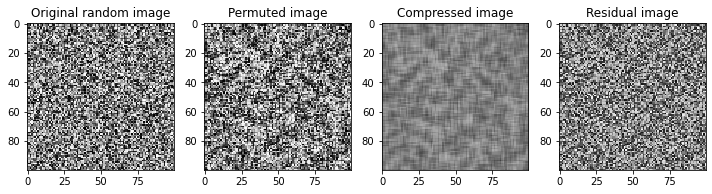

In [6]:
c_im = np.abs(.5*(S1 @ im) + .5*(S1 @ im.T).T)
res_im = np.real(.5*(S2 @ im) + .5*(S2 @ im.T).T) + .5 # +.5 since it is 0-centered.

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 50))
ax1.set_title("Original random image")
ax1.imshow(imOriginal, cmap=mpl.cm.binary, vmin=0, vmax=1, interpolation='nearest')
ax2.set_title("Permuted image")
ax2.imshow(im, cmap=mpl.cm.binary, vmin=0, vmax=1, interpolation='nearest')
ax3.set_title("Compressed image")
ax3.imshow(c_im, cmap=mpl.cm.binary, vmin=0, vmax=1, interpolation='nearest')
ax4.set_title("Residual image")
ax4.imshow(res_im, cmap=mpl.cm.binary, vmin=0, vmax=1, interpolation='nearest')
plt.tight_layout()
plt.show()

I find these results interesting because visually, it is obvious that the permuted image contains much more large-scale features than the original image. However, looking at the compressed image, and the increase between the small decrease between the initial and final norms, the compression really isn't that much. Our eyes are good at detecting the large-scale patterns and filtering out the noise, so the results seem more impressive. It seems like compression would not be worth it for most use-cases; permutation is not a powerful enough operator to produce much compression in the image. Note though that I was being pretty ambitous when choosing compression by an order of magnitude, and we could get better results by increasing $n$.